In [1]:
import time
import torch
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("No GPU available. Using CPU.")




GPU is available. Using GPU.


In [3]:
import GPUtil
import psutil

# Get the GPU details
gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(f"GPU: {gpu.name}, Driver: {gpu.driver}, Memory: {gpu.memoryTotal}MB")

# Get the RAM details
ram = psutil.virtual_memory()
print(f"Total RAM: {ram.total / (1024**3):.2f} GB")

GPU: NVIDIA GeForce RTX 4070 Laptop GPU, Driver: 556.12, Memory: 8188.0MB
Total RAM: 15.70 GB


In [4]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader, TensorDataset

data_directory = 'Sign Language for Alphabets'



In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
])

dataset = datasets.ImageFolder(root=data_directory, transform=transform)




In [6]:
train_size = int(0.7 * len(dataset))
test_size = int(0.15 * len(dataset))
validation_size = len(dataset) - (train_size + test_size)

In [7]:
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [8]:
import torch
import torchvision.models as models

# Load a pretrained AlexNet model
model = models.alexnet(pretrained=True)

c:\Users\akhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\akhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\akhil/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:15<00:00, 16.1MB/s] 


In [9]:
import torch.nn as nn

model.classifier[6] = nn.Linear(4096, 27) 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
model.to(device)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
from tqdm import tqdm
import time

start_time = time.time()
num_epochs = 20
val_accuracies = []
train_accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    # Use tqdm for progress bar
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training", leave=False)
    for inputs, targets in train_loader_tqdm:
        inputs, targets = inputs.to(device), targets.to(device) 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted_train = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted_train == targets).sum().item()

        # Update tqdm description with real-time loss
        train_loader_tqdm.set_postfix(loss=loss.item())

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    # Use tqdm for validation progress bar
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation", leave=False)
    with torch.no_grad():
        for inputs, labels in val_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)  
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {average_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2%}, Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2%}')

end_time = time.time()
time_to_train = end_time - start_time
print(f"Time to train: {time_to_train:.2f} seconds")


Epoch [1/20], Train Loss: 0.3455, Train Accuracy: 89.43%, Validation Loss: 0.1009, Validation Accuracy: 96.87%


Epoch [2/20], Train Loss: 0.0806, Train Accuracy: 97.57%, Validation Loss: 0.0806, Validation Accuracy: 97.54%


Epoch [3/20], Train Loss: 0.0424, Train Accuracy: 98.66%, Validation Loss: 0.0877, Validation Accuracy: 97.61%


Epoch [4/20], Train Loss: 0.0374, Train Accuracy: 98.83%, Validation Loss: 0.0562, Validation Accuracy: 98.42%


Epoch [5/20], Train Loss: 0.0312, Train Accuracy: 99.07%, Validation Loss: 0.0602, Validation Accuracy: 98.45%


Epoch [6/20], Train Loss: 0.0279, Train Accuracy: 99.16%, Validation Loss: 0.0530, Validation Accuracy: 98.70%


Epoch [7/20], Train Loss: 0.0238, Train Accuracy: 99.28%, Validation Loss: 0.0444, Validation Accuracy: 98.81%


Epoch [8/20], Train Loss: 0.0245, Train Accuracy: 99.26%, Validation Loss: 0.0639, Validation Accuracy: 98.52%


Epoch [9/20], Train Loss: 0.0204, Train Accuracy: 99.35%, Validation Loss: 0.0507, Validation Accuracy: 98.69%


Epoch [10/20], Train Loss: 0.0212, Train Accuracy: 99.36%, Validation Loss: 0.0930, Validation Accuracy: 98.07%


Epoch [11/20], Train Loss: 0.0169, Train Accuracy: 99.48%, Validation Loss: 0.0606, Validation Accuracy: 98.50%


Epoch [12/20], Train Loss: 0.0174, Train Accuracy: 99.50%, Validation Loss: 0.0684, Validation Accuracy: 98.60%


Epoch [13/20], Train Loss: 0.0168, Train Accuracy: 99.56%, Validation Loss: 0.0907, Validation Accuracy: 98.15%


Epoch [14/20], Train Loss: 0.0202, Train Accuracy: 99.48%, Validation Loss: 0.0596, Validation Accuracy: 98.76%


Epoch [15/20], Train Loss: 0.0114, Train Accuracy: 99.69%, Validation Loss: 0.0859, Validation Accuracy: 98.49%


Epoch [16/20], Train Loss: 0.0156, Train Accuracy: 99.56%, Validation Loss: 0.0635, Validation Accuracy: 98.87%


Epoch [17/20], Train Loss: 0.0205, Train Accuracy: 99.42%, Validation Loss: 0.0682, Validation Accuracy: 98.67%


Epoch [18/20], Train Loss: 0.0172, Train Accuracy: 99.53%, Validation Loss: 0.0821, Validation Accuracy: 98.60%


Epoch [19/20], Train Loss: 0.0166, Train Accuracy: 99.59%, Validation Loss: 0.0658, Validation Accuracy: 98.77%


Epoch [20/20], Train Loss: 0.0122, Train Accuracy: 99.63%, Validation Loss: 0.0620, Validation Accuracy: 98.76%
Time to train: 3305.29 seconds


In [13]:
torch.save(model.state_dict(), 'Alexnet.h5')

In [14]:
model.eval() 
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) 
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
        
        _, predicted = torch.max(outputs, 1) 
        all_predictions.append(predicted)
        all_labels.append(labels)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct / total

    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}')


Test Loss: 0.0504, Test Accuracy: 98.75%


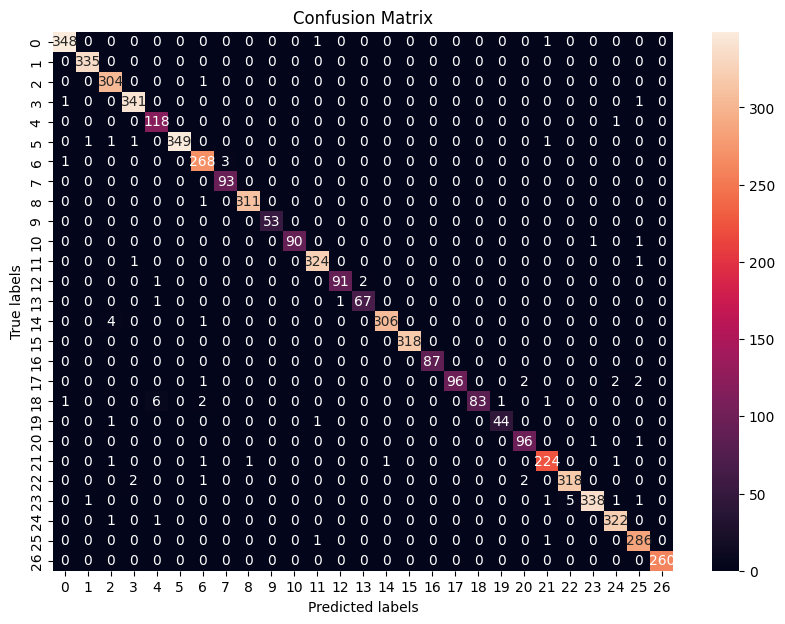

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

val_preds = []
val_targets = []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        val_preds.extend(predicted.cpu().numpy()) 
        val_targets.extend(labels.cpu().numpy()) 

cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [16]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Load the trained model and set to evaluation mode
model =models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(4096, 27) 
model.load_state_dict(torch.load("Alexnet.h5", map_location=torch.device('cpu')))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define transformations for each frameQ
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to preprocess frame and make predictions
def classify_frame(frame, model, device):
    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Convert grayscale to 3 channels
    gray_frame_3ch = cv2.merge([gray_frame, gray_frame, gray_frame])
    
    # Convert the frame to a PIL image and apply transformations
    pil_image = Image.fromarray(gray_frame_3ch)
    image_tensor = transform(pil_image).unsqueeze(0).to(device)

    # Run the image through the model to get prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    return predicted_class.item()

# OpenCV video capture
cap = cv2.VideoCapture(0) 

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    predicted_class = classify_frame(frame, model, device)

    label = f"Class: {predicted_class}"
    cv2.putText(frame, label, (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    gray_display_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow('Live Video Classification', cv2.merge([gray_display_frame, gray_display_frame, gray_display_frame]))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


c:\Users\akhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\akhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
